## Created By : Shreya Dubey
## Abstractive headline predictor model

In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 39kB/s 
     |████████████████████████████████| 450kB 52.3MB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [2]:
import tensorflow as tf

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at : {}'.format(device_name))

Found GPU at : /device:GPU:0


In [0]:
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)	

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
#from attention import AttentionLayer
from nltk.corpus import stopwords

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Processed2.csv to Processed2.csv
User uploaded file "Processed2.csv" with length 6904831 bytes


In [9]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import csv
import nltk

Using TensorFlow backend.


In [0]:
df = pd.read_csv('Processed2.csv')

In [11]:
df.head()

,text,headline
0,the daman and diu administration on wednesday withdrew circular that asked women staff to tie rakhis on male colleagues after the order triggered backlash from employees and was ripped apart on so...,sost daman diu revokes mandatory rakshabandhan in offices order eost
1,from her special numbers to tvappearances bollywood actor malaika arora khan has managed to carve her own identity the actor who made her debut in the hindi film industry with the blockbuster debu...,sost malaika slams user who trolled her for divorcing rich man eost
2,the indira gandhi institute of medical sciences igims in patna amended its marital declaration form on thursday replacing the word virgin with unmarried after controversyuntil now new recruits to ...,sost virgin now corrected to unmarried in igims form eost
3,lashkaretaibas kashmir commander abu dujana was killed in an encounter in village in pulwama district of jammu and kashmir earlier this week dujana who had managed to give the security forces slip...,sost aaj aapne pakad liya let man dujana before being killed eost
4,hotels in mumbai and other indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or do not disturb sign left on the door for days ...,sost hotel staff to get training to spot signs of sex trafficking eost


In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['headline'],test_size=0.1, random_state = 0 , shuffle =True)


In [0]:
# Fixing max length of text and headline
max_text_len=600
max_headline_len=12

In [14]:
x_tr.head()

2709    in provocative remark that will only make the alreadyraging debate over cow slaughter and consumption of beef more heated sadhvi who attended meeting of several hindu outfits in panaji on wednesda...
253     india captain virat kohli has said he is not affected by peoples opinions on his lack of form think people start counting the number of innings when batsman does not score welli was not looking at...
3923    aaj tak live tv with live election results congratulate shri narendra modi and the bjp on their victory in uttar pradesh uttarakhandmy heartiest congratulations to capt amarinder singhji all our p...
1495    australian hockey player tom craig intends to pay his university fees with earnings from the upcoming hockey indian league craig who was bought by the kalinga lancers for 67000 45 lakh said that a...
3139    ever since the racial attack on africans in april in greater noida several such incidents have come to lightalso read attack on nigerian students in greater noi

In [15]:
# Building tokenizer to convert word sequence into integer sequence

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))


# Analysing the number of rare words in the vocabulary (rule: any word that appears 3 or leass times is rare)

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for articles on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

% of rare words in vocabulary: 80.57225215781975
Total Coverage of rare words: 7.879379013248801


In [16]:
# Building tokenizer for headline as well as we did for text

#prepare a tokenizer for headlines on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

# Analysis for rare words in headlines (here threshold is 2 for rare words as the length of headlines is shorter.) 

thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for headlines on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headline_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headline_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

% of rare words in vocabulary: 55.37288539432929
Total Coverage of rare words: 11.232750912298508


In [0]:
# deleting the headlines that only have start and end tokens in them

ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['sost']) and i!=target_word_index['eost']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [19]:
# Building model

from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
#encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, forward_state_h1, forward_state_c1, backward_state_h1, backward_state_c1 = encoder_lstm1(enc_emb)
state_h1 = Concatenate()([forward_state_h1, backward_state_h1])
state_c1 = Concatenate()([forward_state_c1, backward_state_c1])
encoder_states1 = [state_h1, state_c1]

#encoder lstm 2
#encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
#encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output1)
#encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (Non

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [21]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100, batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3719 samples, validate on 413 samples
Epoch 1/100
3719/3719 [==============================] - 79s 21ms/sample - loss: 6.3260 - acc: 0.1809 - val_loss: 5.0311 - val_acc: 0.2789
Epoch 2/100
3719/3719 [==============================] - 65s 17ms/sample - loss: 5.5942 - acc: 0.2224 - val_loss: 4.8883 - val_acc: 0.3066
Epoch 3/100
3719/3719 [==============================] - 66s 18ms/sample - loss: 5.4587 - acc: 0.2437 - val_loss: 4.8832 - val_acc: 0.3462
Epoch 4/100
3719/3719 [==============================] - 65s 18ms/sample - loss: 5.3571 - acc: 0.2754 - val_loss: 4.7889 - val_acc: 0.3634
Epoch 5/100
3719/3719 [==============================] - 65s 18ms/sample - loss: 5.2802 - acc: 0.2984 - val_loss: 4.6631 - val_acc: 0.3691
Epoch 6/100
3719/3719 [==============================] - 65s 18ms/sample - loss: 5.2019 - acc: 0.3091 - val_loss: 4.6251 - val_acc: 0.3696
Epoch 7/100
3719/3719 [==

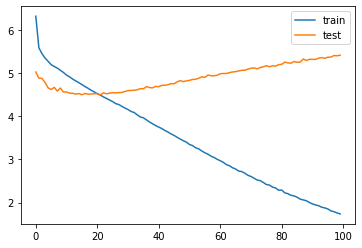

In [22]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
model.save('Abstraction_model_1.h5')
model_file = drive.CreateFile({'title' : 'Abstraction_model_1.h5'})                       
model_file.SetContentFile('Abstraction_model_1.h5')                       
model_file.Upload()

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sost']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eost'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eost'  or len(decoded_sentence.split()) >= (max_headline_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [28]:
for i in range(0,2):
    print("article:",seq2text(x_tr[i]))
    print("Original headline:",seq2summary(y_tr[i]))
    print("Predicted headline:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

article: in provocative remark that will only make the debate over cow slaughter and consumption of beef more heated sadhvi who attended meeting of several hindu outfits in panaji on wednesday triggered fresh row by saying that those who considered eating beef as status symbol should be hanged this remark by sadhvi saraswati who hails from madhya pradesh sharp reaction from the congress which said that her speech would communal hatred and demanded that the bjpled government in goa lodge an fir against appeal to the government of india that those people who consider eating meat of their own mother as status symbol should be hanged saraswati had those who eat beef should be brought before the public and hanged then only people will know that it is our duty to protect gau she said while commenting on beef consumption during the inauguration of the all india hindu convention at village in must keep arms in homes to protect saraswati president of the dharma seva samiti of in madhya pradesh 

In [26]:
for i in range(30,50):
    print("article:",seq2text(x_tr[i]))
    print("Original headline:",seq2summary(y_tr[i]))
    print("Predicted headline:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

article: prime minister narendra modis stern warning to selfproclaimed cow vigilantes seems to have fallen on deaf ears as group of men attacked truck drivers transporting cows in guwahati the incident took place on sunday july according to reports group of cow vigilantes stopped three vehicles transporting cows and beat up the drivers on the outskirts of guwahati the incident took place near some 30 km from capital guwahati the vehicles were coming from in upper assam when the members of the hindu yuva unit stopped them and asked the drivers to step out the men then brutally thrashed the drivers accusing them of cow hindu yuva parishad leader said these people smuggle cattle across the border to bangladesh they transport them in conditions we caught them red handed yesterday in one vehicle they pack 40 50 where there is space for only ten animals we found some of the animals had their limbs fractured but police remain blind to their plight and take bribe from these traders we confisca

In [0]:
original = []
predicted = []
for i in range(len(x_val)):
  original.append(seq2summary(y_val[i]))
  predicted.append(decode_sequence(x_val[i].reshape(1,max_text_len)))


In [30]:
len(predicted)

413

In [31]:
!pip install rouge

In [0]:
from rouge import Rouge

evaluator = Rouge()

In [0]:
ans = evaluator.get_scores(decode_sequence(x_tr[20].reshape(1,max_text_len)),seq2summary(y_tr[20]))

In [34]:
ans

[{'rouge-1': {'f': 0.24999999500000009, 'p': 0.25, 'r': 0.25},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.2499999999995, 'p': 0.25, 'r': 0.25}}]

In [0]:
metric = []
for i in range(len(original)):
  metric.append(evaluator.get_scores(predicted[i],original[i]))


In [0]:
avg_ro_1_r = 0
for i in range(len(metric)):
  avg_ro_1_r = avg_ro_1_r + metric[i][0]['rouge-1']['r']

In [37]:
(avg_ro_1_r/len(metric))*100

6.6813936668658185